# Learning to Deep Learn using Python, Keras, TensorFlow and a GPU

_[Jonathon Hare, 21st Jan 2018](https://github.com/jonhare/DISCnetMachineLearningCourse)_

## Change History

- 20180121: Initial version
- 20180416: Update for DISCnet
- 20190408: Update for DISCnet/2 + Colab

## Introduction

Now we've seen how we can use Keras to work towards the solution of a handwriting recognition problem, we'll turn our focus to data that is more realistic (and focussed on a maritime application), using deep-learning models that are much closer to state of the art. The problem with using better models is that we need massive amounts of labelled data to train these models from scratch, and also large amounts of time (typically days of training, even using multiple GPUs). Rather than training from scratch we'll explore using transfer learning and fine-tuning using pre-trained models. The pre-trained models that we'll play with were trained using the ImageNet dataset, which consists of about 1.3 million images in 1000 classes.

Through this part of the tutorial you'll learn how to:

* How to load image data from the file system
* How to develop and evaluate a simple CNN for classification.
* How to use custom callbacks to monitor training progress.
* How to load a pre-trained model and use it to make classifications.
* How to modify and fine-tune a pre-trained model to solve the a classification problem.
* How to extract _semantic_ features that can be used for transfer learning and finding similar features.

## Prerequisites
To use this tutorial you'll use the Python 3 language with the `keras` deep learning library and the `tensorflow` backend. We'll also use the `scikit-learn` and `numpy` packages. For this lab we'll use a Jupyter notebook running in the cloud on [Google Colab](https://colab.research.google.com). Colab gives us free access to a virtual machine with GPU acceleration and all the prerequisite libraries pre-installed.

In [0]:
__Note:__ in Jupyter Notebooks, commands with an exclaimation mark (!) in front of them are shell commands, and will run just as if typed in a terminal (without the exclaimation mark).

If running locally you'll need access to a computer with the following installed:

- `Python` (> 3.6)
- `keras` (>= 2.0.0)
- `tensorflow` (>= 1.0.0)
- `NumPy` (>= 1.12.1)
- `SciPy` (>= 0.19.1)
- `scikit-learn` (>= 0.19.1)

If you've installed the base Anaconda python distribution, then running `conda install keras` will install both keras and tensorflow. You can make a start on this tutorial using you own machines, however you'll find that the code runs rather slowly. To run at more sensible speeds you need access to a machine with a powerful GPU (or GPUs).

## Getting started 
Start by downloading and unzipping the data set:

In [3]:
!wget https://artist-cloud.ecs.soton.ac.uk/s/wyxs7b59Ohr9LaT/download -O boat-data.zip
!unzip -q boat-data.zip

--2019-05-19 13:20:03--  https://artist-cloud.ecs.soton.ac.uk/s/wyxs7b59Ohr9LaT/download
Resolving artist-cloud.ecs.soton.ac.uk (artist-cloud.ecs.soton.ac.uk)... 152.78.189.87, 2001:630:d0:f104:21e:4fff:fefc:5a7d
Connecting to artist-cloud.ecs.soton.ac.uk (artist-cloud.ecs.soton.ac.uk)|152.78.189.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 266343621 (254M) [application/zip]
Saving to: ‘boat-data.zip’

boat-data.zip       100%[===================>] 254.00M  4.32MB/s    in 64s     

2019-05-19 13:21:07 (4.00 MB/s) - ‘boat-data.zip’ saved [266343621/266343621]

Archive:  boat-data.zip
   creating: data/
   creating: data/valid/
   creating: data/valid/Gondola/
  inflating: data/valid/Gondola/20130410_080145_34221.jpg  
   creating: __MACOSX/
   creating: __MACOSX/data/
   creating: __MACOSX/data/valid/
   creating: __MACOSX/data/valid/Gondola/
  inflating: __MACOSX/data/valid/Gondola/._20130410_080145_34221.jpg  
  inflating: data/valid/Gondola/20130410_09

We'll start by exploring the data, and look at how we can get that data loaded into memory through python code. If you open the data directory you should see three folders:

In [0]:
- The `train` folder contains the training data & is broken into subdirectories for each class. 
- The `valid` folder contains the validation data & is broken into subdirectories for each class. 
- The `test` folder contains the testing data & is broken into subdirectories for each class. 

The keras library has support for directly reading images from a directory structure like the one we have using the `ImageDataGenerator` class. In addition to loading the images directly, keras provides a mechanism to dynamically augment the data being read by applying random transformations (flipping, rotating, etc), as well as cropping and scaling the images. The following code will generate a visualisation of the first batch of images produced by the generator:

Found 3474 images belonging to 16 classes.


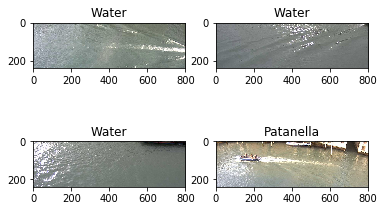

In [4]:
# Plot ad hoc data instances
from keras.preprocessing.image import ImageDataGenerator
import matplotlib
import matplotlib.pyplot as plt
import numpy

datagen = ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_directory(
        'data/train',
        target_size=(240, 800),
        batch_size=4,
        class_mode='categorical')

# generate the first batch
(batch_images, batch_labels) = generator.next()

class_labels = [item[0] for item in sorted(generator.class_indices.items(), key=lambda x: x[1])] #get a list of classes
batch_labels = numpy.argmax(batch_labels, axis=1) #convert the one-hot labels to indices

# plot 4 images
plt.subplot(221).set_title(class_labels[batch_labels[0]])
plt.imshow(batch_images[0], aspect='equal')
plt.subplot(222).set_title(class_labels[batch_labels[1]])
plt.imshow(batch_images[1], aspect='equal')
plt.subplot(223).set_title(class_labels[batch_labels[2]])
plt.imshow(batch_images[2], aspect='equal')
plt.subplot(224).set_title(class_labels[batch_labels[3]])
plt.imshow(batch_images[3], aspect='equal')

# show the plot
plt.show()

You can see that accessing the dataset is quite easy. The most important caveat of using the `ImageDataGenerator` comes when we are using it to load the test data - in such a case we need to ensure that no augmentation happens (other than the resizing of inputs through the `target_size` attribute of `flow_from_directory`), and that the `shuffle` attribute of `flow_from_directory` is `False`, to ensure that we can compare the true labels and target labels correctly.

![Examples from the dataset](https://raw.githubusercontent.com/jonhare/DISCnetMachineLearningCourse/master/Thursday/practical-part2/batch.png "Examples from the dataset")

## A simple CNN for boat classification

Now let's try something a little more challenging and take our _larger_ convolutional network from the experiments with mnist and apply it to the problem of boat classification. Firstly we need to setup the data for training (this time using the generator so we don't have to worry about memory usage), and it would also be sensible to load the validation data to monitor performance during training, as well as load the test data:

In [5]:
import numpy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
 
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# the number of images that will be processed in a single step
batch_size=32
# the size of the images that we'll learn on - we'll shrink them from the original size for speed
image_size=(30, 100)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical')

valid_generator = test_datagen.flow_from_directory(
        'data/valid',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

num_classes = len(train_generator.class_indices)

Found 3474 images belonging to 16 classes.
Found 395 images belonging to 16 classes.
Found 1324 images belonging to 16 classes.


Note that for now we're not using any data augmentation from the training data, however we've structured the code so that we can easily add it by manipulating the `ImageDataGenerator` that creates the `train_datagen` object. 

Now we can add the network definition from part 1. We'll make a slight change to the previous `larger_model()` function so that it allows us to specify the input and output sizes, and we'll also pull out the compile statement as it would be the same for many model architectures:

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D

def larger_model(input_shape, num_classes):
	# create model
	model = Sequential()
	model.add(Convolution2D(30, (5, 5), padding='valid', input_shape=input_shape, activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Convolution2D(15, (3, 3), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(50, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	
	return model

# build the model
model = larger_model(train_generator.image_shape, num_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Specifying the input shape using the shape given by the `train_generator.image_shape` allows us to avoid having to worry about how the backend is storing the images. We're now in a position to add the code to fit the model. Because this time we're loading the data using a generator rather than statically we use the `fit_generator()` method instead of `fit`:

In [7]:
# Fit the model
# Fit the model
model.fit_generator(
        train_generator,
        steps_per_epoch=3474 // batch_size, 
        validation_data=valid_generator,
        validation_steps=395 // batch_size,
        epochs=10,
        verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
108/108 [==============================] - 15s 136ms/step - loss: 1.4965 - acc: 0.5851 - val_loss: 1.2161 - val_acc: 0.6406
Epoch 2/10
108/108 [==============================] - 12s 110ms/step - loss: 0.9861 - acc: 0.7083 - val_loss: 1.1289 - val_acc: 0.6391
Epoch 3/10
108/108 [==============================] - 12s 112ms/step - loss: 0.8837 - acc: 0.7274 - val_loss: 1.0601 - val_acc: 0.6612
Epoch 4/10
108/108 [==============================] - 12s 109ms/step - loss: 0.8136 - acc: 0.7455 - val_loss: 0.8978 - val_acc: 0.7107
Epoch 5/10
108/108 [==============================] - 12s 109ms/step - loss: 0.7451 - acc: 0.7579 - val_loss: 0.9285 - val_acc: 0.7052
Epoch 6/10
108/108 [==============================] - 12s 109ms/step - loss: 0.7009 - acc: 0.7713 - val_loss: 0.8594 - val_acc: 0.7080
Epoch 7/10
108/108 [==============================] - 13s 122ms/step - loss: 0.6664 - acc: 0.7865 - val_loss: 0.7529 - val_acc: 0.7493
Epoch 8

We've specified `3474 // batch_size` `steps_per_epoch` to indicate that we want all images (there are 3474 training images) to be processed each epoch (each step within an epoch will process a single batch worth of images). The same applies for the `validation_steps`.

Finally, before we try running this model, lets make use of the test data and print a classification report using scikit-learn:

In [8]:
# Final evaluation of the model
# Compute the number of epochs required so we see all data:
test_steps_per_epoch = numpy.math.ceil(float(test_generator.samples) / test_generator.batch_size)
# perform prediction:
raw_predictions = model.predict_generator(test_generator, steps=test_steps_per_epoch)
# convert predictions from one-hot to indices
predictions = numpy.argmax(raw_predictions, axis=1)

print("Prediction Distribution:  " + str(numpy.bincount(predictions)))
print("Groundtruth Distribution: " + str(numpy.bincount(test_generator.classes)))

from sklearn import metrics
#get a list of classes (this basically ensures that the list is in the correct order by index):
class_labels = [item[0] for item in sorted(test_generator.class_indices.items(), key=lambda x: x[1])] #get a list of classes
#print the report
print(metrics.classification_report(test_generator.classes, predictions, target_names=class_labels))

Prediction Distribution:  [ 16  12  14   0   0   8   2   0 369 179   8  10   0   2 322 382]
Groundtruth Distribution: [ 19  22  51   3   7  59   3   1 274  74  15  19   3  29 325 420]
                         precision    recall  f1-score   support

              Alilaguna       0.81      0.68      0.74        19
              Ambulanza       0.25      0.14      0.18        22
               Barchino       0.36      0.10      0.15        51
                Gondola       0.00      0.00      0.00         3
          Lanciafino10m       0.00      0.00      0.00         7
              Motobarca       0.62      0.08      0.15        59
Motopontonerettangolare       1.00      0.67      0.80         3
          MotoscafoACTV       0.00      0.00      0.00         1
               Mototopo       0.68      0.92      0.78       274
              Patanella       0.31      0.74      0.43        74
                Polizia       0.12      0.07      0.09        15
        Raccoltarifiuti       0.30 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Running this should result in the following:

In [0]:
Using TensorFlow backend.
Found 3474 images belonging to 16 classes.
Found 395 images belonging to 16 classes.
Found 1324 images belonging to 16 classes.
Epoch 1/10
2018-01-22 20:04:10.049850: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-22 20:04:10.049882: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-22 20:04:10.318579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-01-22 20:04:10.319339: I tensorflow/core/common_runtime/gpu/gpu_device.cc:887] Found device 0 with properties: 
name: GeForce GTX TITAN X
major: 5 minor: 2 memoryClockRate (GHz) 1.076
pciBusID 0000:02:00.0
Total memory: 11.92GiB
Free memory: 11.80GiB
2018-01-22 20:04:10.319363: I tensorflow/core/common_runtime/gpu/gpu_device.cc:908] DMA: 0 
2018-01-22 20:04:10.319372: I tensorflow/core/common_runtime/gpu/gpu_device.cc:918] 0:   Y 
2018-01-22 20:04:10.319382: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:02:00.0)
108/108 [==============================] - 16s - loss: 1.5000 - acc: 0.5810 - val_loss: 1.2083 - val_acc: 0.6458
Epoch 2/10
108/108 [==============================] - 14s - loss: 0.9916 - acc: 0.7089 - val_loss: 1.0109 - val_acc: 0.6953
Epoch 3/10
108/108 [==============================] - 15s - loss: 0.8990 - acc: 0.7267 - val_loss: 0.9910 - val_acc: 0.6979
Epoch 4/10
108/108 [==============================] - 14s - loss: 0.8057 - acc: 0.7448 - val_loss: 0.9089 - val_acc: 0.7057
Epoch 5/10
108/108 [==============================] - 15s - loss: 0.7490 - acc: 0.7596 - val_loss: 0.8997 - val_acc: 0.7109
Epoch 6/10
108/108 [==============================] - 14s - loss: 0.7212 - acc: 0.7685 - val_loss: 0.8566 - val_acc: 0.7344
Epoch 7/10
108/108 [==============================] - 15s - loss: 0.6559 - acc: 0.7814 - val_loss: 0.8229 - val_acc: 0.7474
Epoch 8/10
108/108 [==============================] - 15s - loss: 0.5935 - acc: 0.8124 - val_loss: 0.7744 - val_acc: 0.7422
Epoch 9/10
108/108 [==============================] - 14s - loss: 0.5697 - acc: 0.8118 - val_loss: 0.8121 - val_acc: 0.7578
Epoch 10/10
108/108 [==============================] - 14s - loss: 0.5146 - acc: 0.8290 - val_loss: 0.8322 - val_acc: 0.7552
Prediction Distribution:  [ 19  22  51   3   7  59   3   1 274  74  15  19   3  29 325 420]
Groundtruth Distribution: [ 16  12  21   1   0  58   3   1 298 164  10  25   0   5 334 376]
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
                         precision    recall  f1-score   support

              Alilaguna       0.88      0.74      0.80        19
              Ambulanza       0.50      0.27      0.35        22
               Barchino       0.19      0.08      0.11        51
                Gondola       0.00      0.00      0.00         3
          Lanciafino10m       0.00      0.00      0.00         7
              Motobarca       0.26      0.25      0.26        59
Motopontonerettangolare       0.33      0.33      0.33         3
          MotoscafoACTV       1.00      1.00      1.00         1
               Mototopo       0.78      0.85      0.81       274
              Patanella       0.34      0.76      0.47        74
                Polizia       0.20      0.13      0.16        15
        Raccoltarifiuti       0.20      0.26      0.23        19
           Sandoloaremi       0.00      0.00      0.00         3
                   Topa       0.40      0.07      0.12        29
          VaporettoACTV       0.97      0.99      0.98       325
                  Water       0.98      0.88      0.92       420

            avg / total       0.78      0.78      0.77      1324

In this particular case the overall accuracies are a bit mixed; whist the average is high, it is clear that our model doesnt work well for some classes. Be aware though that we're using a relatively small set of both training and validation data, and that there is a very high bias in the class distribution which inevitably could lead to higher accuracies because of common classes. As we mentioned in the first tutorial, this network architecture isn't any thing like one that has won the image classificiation challenges.

> __Exercise:__ Have a play with the above code and explore the effect of patch size and the amount of training and validation data.

## Using a better network model - transferring and finetuning a pretrained ResNet
Training a network from scratch can be a lot of work. Is there some way we could take an existing network trained on some data with one set of labels, and adapt it to work on a different data set with different labels? Assuming that the inputs of the network are equivalent (for example, image with the same number of bands and size), then the answer is an emphatic yes! This process of "finetuning" a pre-trained network has become common-place as its much faster an easier than starting from scratch. This approach will also help us better work with the small amount of data that we have to train with.

Let's try this in practice - we'll start by loading a pre-trained network architecture called a Deep Residual Network (or ResNet for short) that has been trained on the 1000-class ImageNet dataset. The ResNet architecture is very deep - it has many (in our case 50) convolutional layers and is currently one of the best performing architectures on the ImageNet challenge. Keras contains code that implements the resnet50 architecture, and automatically downloads the pre-trained model weights. We'll start by using this to load the model and test it by classifying an image:

In [9]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np

model = ResNet50(include_top=True, weights='imagenet')

img_path = 'data/mf.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds))

40960/35363 [==================================] - 0s 2us/step
Predicted: [[('n02514041', 'barracouta', 0.6744443), ('n02641379', 'gar', 0.2494176), ('n02640242', 'sturgeon', 0.05969239), ('n02536864', 'coho', 0.013348877), ('n01484850', 'great_white_shark', 0.0026125952)]]


If we run this (it will take a little longer the first time as the model is downloaded), it should print the following:

In [10]:
Using TensorFlow backend.
2018-01-22 20:16:24.976367: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-22 20:16:24.976402: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-22 20:16:25.229794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-01-22 20:16:25.230492: I tensorflow/core/common_runtime/gpu/gpu_device.cc:887] Found device 0 with properties: 
name: GeForce GTX TITAN X
major: 5 minor: 2 memoryClockRate (GHz) 1.076
pciBusID 0000:02:00.0
Total memory: 11.92GiB
Free memory: 11.80GiB
2018-01-22 20:16:25.230515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:908] DMA: 0 
2018-01-22 20:16:25.230527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:918] 0:   Y 
2018-01-22 20:16:25.230537: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:02:00.0)
24576/35363 [===================>..........] - ETA: 0s('Predicted:', [[(u'n02640242', u'sturgeon', 0.70169324), (u'n02641379', u'gar', 0.16568515), (u'n02514041', u'barracouta', 0.095400475), (u'n02536864', u'coho', 0.032304522), (u'n01484850', u'great_white_shark', 0.0041837287)]])

SyntaxError: ignored

Indicating that our input image was likely to contain a fish! The `preprocess_input` function is important - it's responsible for applying the same operations to out input image as were applied to the images when the network was trained.

> __Exercise:__ try the model with some of your own images

We're now in a position to start to hack the model structure. Fundamentally we need to first remove the classification layer at the end of the model and replace it with a new one (with a different number of classes):

In [22]:
from keras.models import Model
from keras import optimizers

def hack_resnet(input_size, num_classes):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_size)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax', name='fc1000')(x)
    
    # this is the model we will train
    newmodel = Model(inputs=base_model.input, outputs=x)

    return newmodel

model = hack_resnet((224, 224, 3), num_classes)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


The actual process of finetuning involves us now training the model with our own data. This is as simple as compiling the model and running the `fit` or `fit_generator` methods as before. As the network is already largely trained, we'll likely want to use a small learning rate so not to make big changes in weights:

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

Often we'll first "freeze" the weights of the already trained layers whilst we learn initial weights for our new layer to avoid overfitting before training:

In [0]:
# set weights in all but last layer
# to non-trainable (weights will not be updated)
for layer in model.layers[:len(model.layers)-2]:
    layer.trainable = False

If we have lots of training data we could then unlock these layers and perform end-to-end finetuning afterwards. The Standford CS231n course pages have lots of useful hints on fine-tuning: http://cs231n.github.io/transfer-learning/

> __Exercise:__ try finetuning the resnet50 with the boat data. You'll need a GPU to do this effectively as it's _rather_ slow! Note that you should set the image_size to be (240, 800) as the resnet has minimum size limits on which it can operate. You'll also need to adjust the input images by applying the `preprocess_input` function - you can modify both `ImageDataGenerator` constructor calls to `ImageDataGenerator(preprocessing_function=preprocess_input)` to achieve this.

## Extracting features from a model

Sometimes you want to do things that are not so easily accomplished with a deep network. You might want to build classifiers using very small amounts of data, or you might want a way of finding things in photographs that are in some way semantically similar, but don't have exactly the same classes. CNNs can actually help here using a technique known often called transfer learning (and related to the fine tuning that we just looked at). If we assume we have a trained network, then by extracting vectors from the layers before the final classifier we should have a means of achieving these tasks, as the vectors are likely to strongly encode semantic information about the content of the input image. If we wanted to quickly train new classifiers for new classes, we could for instance just use a relatively simple linear classifier trained on these vectors. If we wanted to find semantically similar images, we could just compare the Euclidean distance of these vectors.

Keras makes it pretty easy to get these vector representations. The following code gets a resnet model in which the a feature vector is computed from the penultimate layer of the network by applying a _global average pooling_ operation over the feature maps:

In [0]:
model = ResNet50(include_top=False,
            weights='imagenet',
            pooling='avg')

With this model, we can use the `predict()` method to extract the features for some inputs. To demonstrate, we can put the whole thing together and generate a vector from an image

In [26]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Model
from keras.preprocessing import image
import numpy as np

model = ResNet50(include_top=False,
            weights='imagenet',
            pooling='avg')

img_path = 'data/test/Alilaguna/20130412_064059_20202.jpg'
img = image.load_img(img_path, target_size=(240, 800))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
features = model.predict(x)

print(features.shape)
print(features)

(1, 2048)
[[0.02248765 0.10492118 0.10726153 ... 1.4908721  0.13007808 0.6482054 ]]


(Obviously this will be more effective if the network has been trained or fine-tuned on the same kind of data that we're extracting features from.)

> __Exercise:__ try generating some features for different patches and calculating the Euclidean distances between these features. How do the Euclidean distances compare to your perception of similarity between the patches?

> __Exercise:__ Can you train a set of SVMs to learn the boat classes using the features extracted by a ResNet? How does the performance compare to the finetuned ResNet? What's the difference in runtime?